## Query the KG for interesting BGCs

In [1]:
!pip install -qr requirements.txt

In [6]:
!bash mount_efs.sh

In [2]:
from dotenv import load_dotenv
import os

from graph_db.db_connection import Neo4jConnection

load_dotenv()
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

In [3]:
from src.io import save_results_to_tsv

query = """
MATCH (bgc:BGC)
WHERE bgc.bgc_class = $bgc_class AND bgc.on_edge = "False"
OPTIONAL MATCH (g:Genome)-[:CONTAINS]->(bgc)
OPTIONAL MATCH (g)-[:ORIGINATED_FROM]->(s:Sample)
WHERE 
   ($min_temp IS NULL OR toFloat(s.temperature) >= $min_temp) AND
   ($max_temp IS NULL OR toFloat(s.temperature) <= $max_temp) AND
   ($min_lat IS NULL OR toFloat(s.latitude) >= $min_lat) AND
   ($max_lat IS NULL OR toFloat(s.latitude) <= $max_lat) AND
   ($min_lon IS NULL OR toFloat(s.longigute) >= $min_lon) AND
   ($max_lon IS NULL OR toFloat(s.longigute) <= $max_lon) AND
   ($min_depth IS NULL OR toFloat(s.depth) >= $min_depth) AND
   ($max_depth IS NULL OR toFloat(s.depth) <= $max_depth)
RETURN 
   bgc.bgc_id AS bgc_id,
   bgc.bgc_class AS bgc_class,
   bgc.bgc_length AS bgc_length,
   bgc.file AS bgc_file,
   g.genome_id AS genome_id,
   g.gtdb_classification AS gtdb_classification,
   s.biosample_id AS sample_id,
   s.temperature AS sample_temperature,
   s.depth AS sample_depth,
   s.latitude AS sample_latitude,
   s.longigute AS sample_longitude
LIMIT $limit
"""

params = {
    "bgc_class": "terpene",
    "min_temp": None,
    "max_temp": None,
    "min_lat": None,
    "max_lat": None,
    "min_lon": None,
    "max_lon": None,
    "min_depth": None,
    "max_depth": None,
    "limit": 50000
}

conn = Neo4jConnection(uri, username, password)

bgc_results = conn.query(query, parameters=params)
#save_results_to_tsv(bgc_results, f"outputs/bgc_query/terpene_bgcs.tsv")

In [6]:
bgc_results[0].data()

{'bgc_id': 'OceanDNA-b3434_00023',
 'bgc_class': 'terpene',
 'bgc_length': None,
 'bgc_file': '/mnt/efs/sandbox/sandbox/development/epereira/bioprospecting/results/oceandna_bgc_catalog/OceanDNA-b3434/bgc_annot/inter/antismash/gbks/OceanDNA-b3434_00023.region001.gbk',
 'genome_id': 'OceanDNA-b3434',
 'gtdb_classification': 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__J057;f__J057;g__;s__',
 'sample_id': None,
 'sample_temperature': None,
 'sample_depth': None,
 'sample_latitude': None,
 'sample_longitude': None}

In [45]:
import pandas as pd
from src.visualization import plot_bgc_statistics

terpene_data = pd.read_csv("outputs/bgc_query/terpene_bgcs.tsv", sep="\t")
bgc_data = {
    'terpene': terpene_data
}

plot_bgc_statistics(
    processed_data=bgc_data,
    shp_file_path="data/maps/ne_110m_ocean/ne_110m_ocean.shp",
    output_dir="outputs/figures",
    base_font_size=14,
)

All figures have been saved to outputs/figures


<img src="outputs/figures/bgc_class_terpene_statistics.png" alt="results1">

In [4]:
import pandas as pd

terpene_data = pd.read_csv("outputs/bgc_query/terpene_bgcs.tsv", sep="\t")
deep_terpene_data = terpene_data[
    (terpene_data['sample_depth'] > 3000) & 
    (terpene_data['sample_depth'].notna()) & 
    (terpene_data['sample_temperature'].notna())
]
deep_terpene_data.head()

,bgc_id,bgc_class,bgc_length,bgc_file,genome_id,gtdb_classification,sample_id,sample_temperature,sample_depth,sample_latitude,sample_longitude
36,OceanDNA-b43061_00076_140-4614,terpene,NaN,/mnt/efs/sandbox/sandbox/development/epereira/...,OceanDNA-b43061,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN05422111,1.4922,4001.0,-31.8100,6.8400
285,OceanDNA-b19211_00044_48-9649,terpene,NaN,/mnt/efs/sandbox/sandbox/development/epereira/...,OceanDNA-b19211,d__Bacteria;p__Marinisomatota;c__Marinisomatia...,SAMN05422171,1.5728,3501.0,-28.4063,179.1413
363,OceanDNA-b14692_00041_650-10223,terpene,NaN,/mnt/efs/sandbox/sandbox/development/epereira/...,OceanDNA-b14692,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,SAMN05422138,1.4542,4003.0,-15.8300,-33.4100
420,OceanDNA-b17563_00281_89-3482,terpene,NaN,/mnt/efs/sandbox/sandbox/development/epereira/...,OceanDNA-b17563,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,SAMN04578346,1.8200,5002.0,10.9107,-44.6678
482,OceanDNA-b42493_00110_87-3596,terpene,NaN,/mnt/efs/sandbox/sandbox/development/epereira/...,OceanDNA-b42493,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,SAMN05422171,1.5728,3501.0,-28.4063,179.1413


In [7]:
from src.databases import extract_protein_data_from_gbk

#gbk_file = (
#    "/home/ec2-user/SageMaker/efs/sandbox/sandbox/development/"
#    "epereira/bioprospecting/results/oceandna_bgc_catalog/"
#    "OceanDNA-b29856/bgc_annot/inter/deepbgc/gbks/OceanDNA-b29856_00043.region001.gbk"
#)
selected_idx = 1
selected_bgc = deep_terpene_data.iloc[selected_idx,:]
selected_bgc_id = selected_bgc["bgc_id"]
gbk_file = "/home/ec2-user/SageMaker/" + selected_bgc["bgc_file"].replace("/mnt/", "")
print(f"Selected BGC ID: {selected_bgc_id}")
print("GBK file")
print(gbk_file)

protein_data = extract_protein_data_from_gbk(gbk_file)
protein_ids = [p for p in protein_data]
protein_ids

Selected BGC ID: OceanDNA-b19211_00044_48-9649
GBK file
/home/ec2-user/SageMaker/efs/sandbox/sandbox/development/epereira/bioprospecting/results/oceandna_bgc_catalog/OceanDNA-b19211/bgc_annot/inter/deepbgc/gbks/OceanDNA-b19211_00044.region001.gbk


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/Bio/GenBank/__init__.py:368: BiopythonParserWarning: Non-upper case molecule type in LOCUS line: dna
  warnings.warn(


['OceanDNA-b19211_00044_1',
 'OceanDNA-b19211_00044_2',
 'OceanDNA-b19211_00044_3',
 'OceanDNA-b19211_00044_4',
 'OceanDNA-b19211_00044_5',
 'OceanDNA-b19211_00044_6',
 'OceanDNA-b19211_00044_7',
 'OceanDNA-b19211_00044_8',
 'OceanDNA-b19211_00044_9',
 'OceanDNA-b19211_00044_10']

## Query KG to assign ec number and chemical reactions to BGC proteins

<img src="imgs/bgc_chemicals.png" alt="bgc">

In [8]:
query = """
MATCH (p:Protein)
WHERE p.protein_id IN $protein_id_list
WITH p, p.ec_numbers AS protein_ec_numbers
OPTIONAL MATCH (r:Reaction)
WHERE ANY(ec IN protein_ec_numbers WHERE ec IN r.ec_numbers)
RETURN p.protein_id AS protein_id, p.name AS protein_name, protein_ec_numbers AS ec_numbers, COLLECT(DISTINCT r.reaction_id) AS reaction_ids
"""

query = """
MATCH (p:Protein)
WHERE p.protein_id IN $protein_id_list
WITH p, p.ec_numbers AS protein_ec_numbers
OPTIONAL MATCH (r:Reaction)
WHERE ANY(ec IN protein_ec_numbers WHERE ec IN r.ec_numbers)
WITH p, protein_ec_numbers, r
ORDER BY r.reaction_id
RETURN 
    p.protein_id AS protein_id, 
    p.name AS protein_name, 
    protein_ec_numbers AS ec_numbers, 
    COLLECT(r.reaction_id) AS reaction_ids,
    COLLECT(r.equation) AS reaction_equations,
    COLLECT(r.deltag) AS reaction_deltags
"""

conn = Neo4jConnection(uri, username, password)

results = conn.query(query, parameters={"protein_id_list": protein_ids})

In [9]:
import pandas as pd

df = pd.DataFrame(results, columns=results[0].keys())
df

,protein_id,protein_name,ec_numbers,reaction_ids,reaction_equations,reaction_deltags
0,OceanDNA-b19211_00044_8,"tryptophan 2,3-dioxygenase [EC:1.13.11.11]",[1.13.11.11],"[rxn00478, rxn25059]",[(1) cpd00007[0] + (1) cpd00065[0] => (1) cpd0...,"[-82.24, -82.24]"
1,OceanDNA-b19211_00044_2,kynureninase [EC:3.7.1.3],[3.7.1.3],"[rxn00728, rxn01930, rxn02767, rxn13182, rxn19...",[(1) cpd00001[0] + (1) cpd00275[0] => (1) cpd0...,"[-12.1, -12.1, -12.09, -12.1, -12.1]"
2,OceanDNA-b19211_00044_10,methylenetetrahydrofolate dehydrogenase (NADP+...,"[3.5.4.9, 1.5.1.5]","[rxn00907, rxn01211, rxn24147, rxn30158, rxn30...",[(1) cpd00006[0] + (1) cpd00125[0] <=> (1) cpd...,"[2.04, -1.3, 10000000.0, 2.04, -1.3, -2.04, -2..."
3,OceanDNA-b19211_00044_1,kynurenine 3-monooxygenase [EC:1.14.13.9],[1.14.13.9],"[rxn01438, rxn13171, rxn19994, rxn19995]",[(1) cpd00005[0] + (1) cpd00007[0] + (1) cpd00...,"[-105.96, -105.96, -105.96, -105.96]"
4,OceanDNA-b19211_00044_4,"3-hydroxyanthranilate 3,4-dioxygenase [EC:1.13...",[1.13.11.6],[rxn01927],[(1) cpd00007[0] + (1) cpd00483[0] => (1) cpd0...,[-59.93]
5,OceanDNA-b19211_00044_6,aminomuconate-semialdehyde/2-hydroxymuconate-6...,"[1.2.1.32, 1.2.1.85]","[rxn01993, rxn02744, rxn03654, rxn40789, rxn42...",[(1) cpd00001[0] + (1) cpd00003[0] + (1) cpd00...,"[-9.06, -8.63, -8.06, -9.06, -8.63]"
6,OceanDNA-b19211_00044_5,2-aminomuconate deaminase [EC:3.5.99.5],[3.5.99.5],"[rxn02743, rxn18182, rxn42805]",[(1) cpd00001[0] + (1) cpd01496[0] => (1) cpd0...,"[-6.73, -6.73, -6.73]"
7,OceanDNA-b19211_00044_3,aminocarboxymuconate-semialdehyde decarboxylas...,[4.1.1.45],[rxn03003],[(1) cpd00067[0] + (1) cpd02692[0] => (1) cpd0...,[-3.63]
8,OceanDNA-b19211_00044_5,2-iminobutanoate/2-iminopropanoate deaminase [...,[3.5.99.10],[rxn43798],[(1) cpd00001[0] + (1) cpd33054[0] <=> (1) cpd...,[21.7]


In [10]:
from src.databases import extract_reaction_data

reactions_path = "data/modelSEED/reactions.json"
compounds_path = "data/modelSEED/compounds.json"

reactions, compounds = extract_reaction_data(reactions_path, compounds_path)

Graph saved to outputs/bgc_query/largest_subnetwork_OceanDNA-b19211_00044_48-9649_improved.png


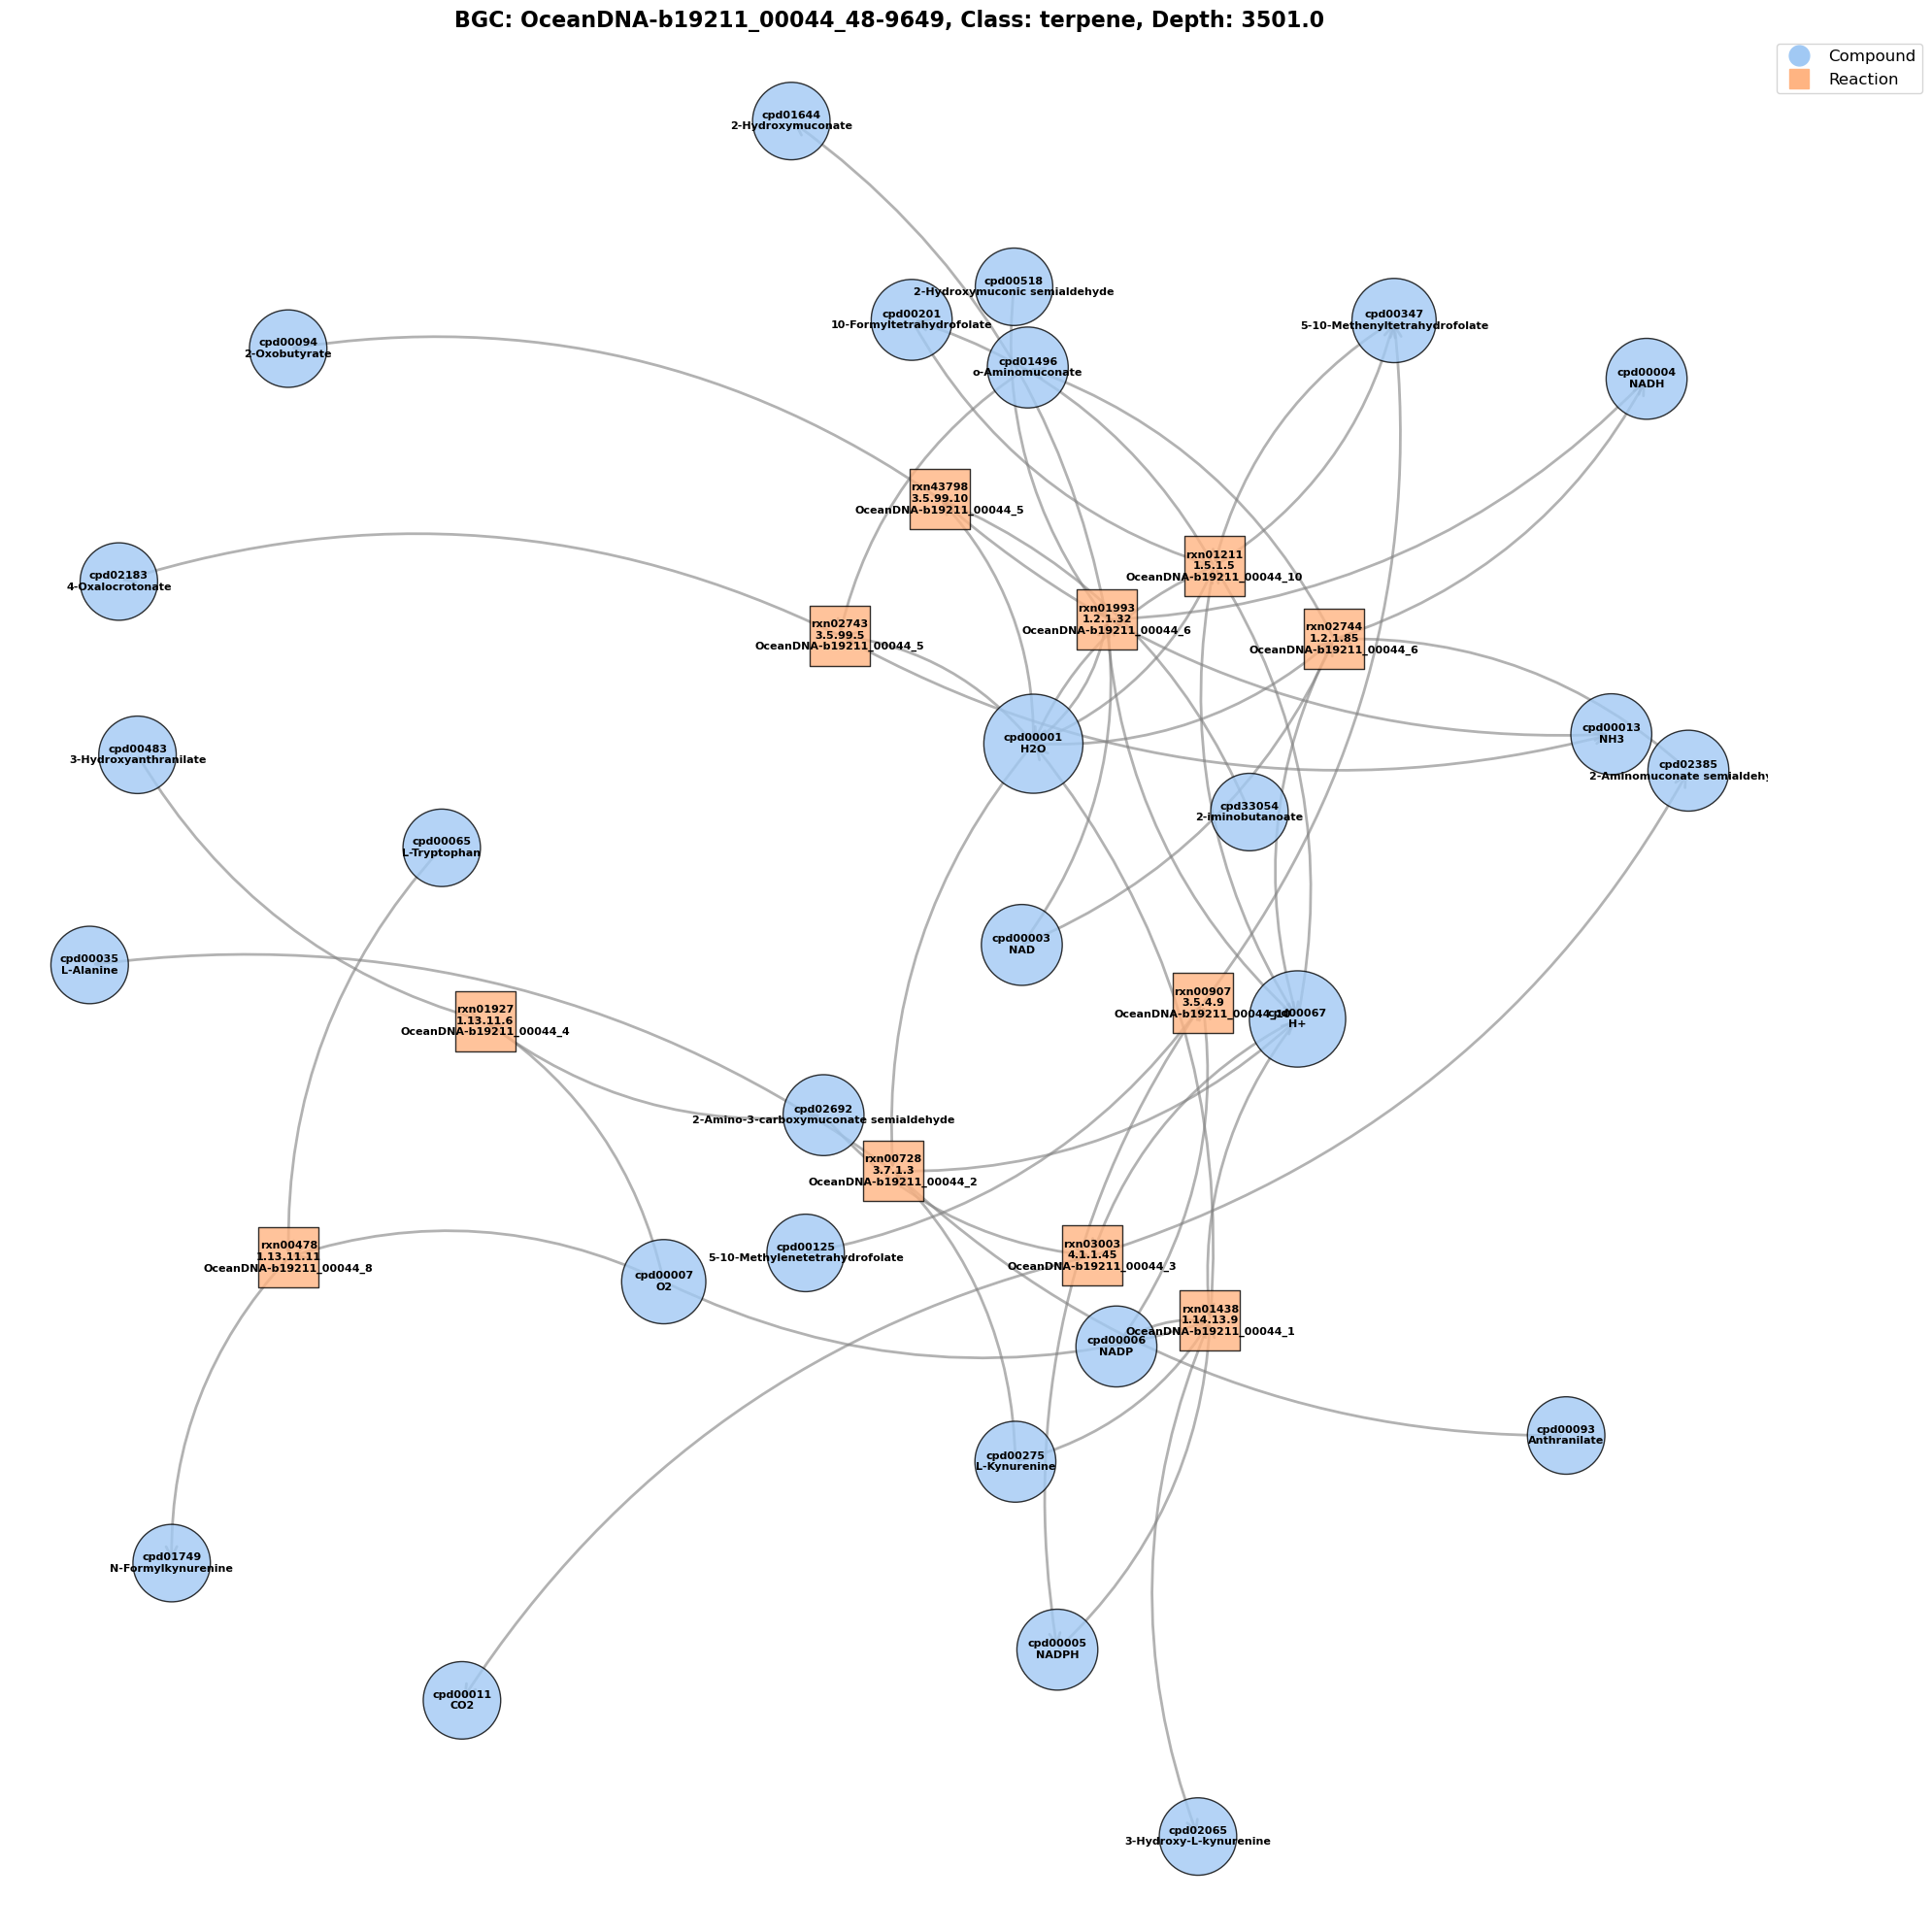

In [30]:
from src.visualization import analyze_minimal_metabolic_network, visualize_advanced_metabolic_network

result_df, G = analyze_minimal_metabolic_network(df, compounds)
visualize_advanced_metabolic_network(
    G,
    save_path=f"outputs/bgc_query/largest_subnetwork_{selected_bgc_id}_improved.png",
    title=f"BGC: {selected_bgc_id}, Class: {selected_bgc['bgc_class']}, Depth: {selected_bgc['sample_depth']}",
    layout="sring"
)

In [ ]:
from src.visualization import analyze_minimal_metabolic_network, visualize_largest_subnetwork

result_df, G = analyze_minimal_metabolic_network(df, compounds)
visualize_largest_subnetwork(
    G, save_path=f"outputs/bgc_query/largest_subnetwork_{selected_bgc_id}.png",
    title=f"BGC: {selected_bgc_id}, Class: {selected_bgc['bgc_class']}, Depth: {selected_bgc['sample_depth']}",
    circular_layout=True)

<img src="outputs/figures/largest_subnetwork_OceanDNA-b19211_00044_48-9649.png" alt="metnet">

### Check if protein sequences coincide

In [9]:
import pandas as pd
from src.databases import group_by_mag, retrieve_sequences


oceandna_dir = ("/home/ec2-user/SageMaker/efs/sandbox/sandbox/development/jolespin/"
                "EC2_WorkingDirectory/science/Databases/NewAtlantisPlanktonic"
                "/Sources/OceanDNA/Genomes/Prokaryotic/"
               )
outfaafile = f"outputs/bgc_query/{selected_bgc_id}_oceandna_sequences.faa"

mag_groups = group_by_mag(protein_ids)
retrieve_sequences(oceandna_dir, mag_groups, outfaafile)

In [10]:
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Levenshtein import ratio

def parse_faa_file(file_path):
    return SeqIO.to_dict(SeqIO.parse(file_path, "fasta"))

def extract_protein_id(header):
    return header.split()[0]

def compare_sequences(seq1, seq2):
    return ratio(str(seq1), str(seq2))

def main(faa_file_path, dict_sequences):
    faa_records = parse_faa_file(faa_file_path)
    
    sim_results = []
    for protein_id, dict_seq in dict_sequences.items():
        if protein_id in faa_records:
            faa_seq = str(faa_records[protein_id].seq)
            similarity = compare_sequences(faa_seq, dict_seq)
            sim_results.append((protein_id, similarity))
        else:
            sim_results.append((protein_id, "Not found in .faa file"))
    
    return sim_results



sim_results = main(outfaafile, protein_data)

for protein_id, similarity in sim_results:
    print(f"Protein ID: {protein_id}")
    if isinstance(similarity, float):
        print(f"Similarity: {similarity:.2%}")
    else:
        print(f"Similarity: {similarity}")
    print()

Protein ID: OceanDNA-b19211_00044_1
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_2
Similarity: 99.76%

Protein ID: OceanDNA-b19211_00044_3
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_4
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_5
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_6
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_7
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_8
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_9
Similarity: 100.00%

Protein ID: OceanDNA-b19211_00044_10
Similarity: 100.00%



## Query the KG for specific compound type: Polyketide

Specifically, POP-FAs: https://www.sciencedirect.com/science/article/pii/S2542435122002380

POP-FAs not a category of BGC-class, so try to find POP-FAs within chemical compounds in internal database and cross link with BGCs of class Polyketide

In [2]:
!pip install -qr requirements.txt

In [3]:
from dotenv import load_dotenv
import pandas as pd
import os

from graph_db.db_connection import Neo4jConnection

load_dotenv()
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

In [6]:
# Get nimber of unique BGC classes in KG
query = """
MATCH (bgc:BGC)
RETURN DISTINCT bgc.bgc_class AS UniqueClasses
ORDER BY UniqueClasses
"""

conn = Neo4jConnection(uri, username, password)

results = conn.query(query)
df = pd.DataFrame(results, columns=results[0].keys())
df.values

array([['2dos'],
       ['acyl_amino_acids'],
       ['alkaloid'],
       ['amglyccycl'],
       ['arylpolyene'],
       ['betalactone'],
       ['blactam'],
       ['butyrolactone'],
       ['cdps'],
       ['crocagin'],
       ['cyanobactin'],
       ['cyclic-lactone-autoinducer'],
       ['darobactin'],
       ['ectoine'],
       ['furan'],
       ['hgle-ks'],
       ['hr-t2pks'],
       ['hserlactone'],
       ['hydrogen-cyanide'],
       ['indole'],
       ['isocyanide'],
       ['ladderane'],
       ['lanthipeptide-class-i'],
       ['lanthipeptide-class-ii'],
       ['lanthipeptide-class-iii'],
       ['lanthipeptide-class-iv'],
       ['lanthipeptide-class-v'],
       ['lap'],
       ['lassopeptide'],
       ['linaridin'],
       ['methanobactin'],
       ['microviridin'],
       ['mycosporine-like'],
       ['naggn'],
       ['napaa'],
       ['ni-siderophore'],
       ['nrp'],
       ['nrp-metallophore'],
       ['nrp;polyketide'],
       ['nrp;saccharide'],
       ['nrps'],


In [9]:
query = """
MATCH (bgc:BGC)
WHERE bgc.bgc_class IN ["pks-like", "polyketide"]
RETURN bgc.bgc_id, bgc.bgc_class, bgc.genome_id, bgc.start, bgc.end
ORDER BY bgc.bgc_class, bgc.bgc_id
"""

conn = Neo4jConnection(uri, username, password)

results = conn.query(query)
df = pd.DataFrame(results, columns=results[0].keys())
df.head()

,bgc.bgc_id,bgc.bgc_class,bgc.genome_id,bgc.start,bgc.end
0,OceanDNA-b12498_00131,pks-like,OceanDNA-b12498,0,7699
1,OceanDNA-b12499_00085,pks-like,OceanDNA-b12499,0,8113
2,OceanDNA-b16040_00037,pks-like,OceanDNA-b16040,0,13196
3,OceanDNA-b17185_00494,pks-like,OceanDNA-b17185,0,3379
4,OceanDNA-b17185_00950,pks-like,OceanDNA-b17185,0,1448
